In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
sys.path.append('./deps/sparse_rrt-1')
from sparse_rrt import _sst_module
from sparse_rrt.systems import standard_cpp_systems
import random


In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state, frame_size=0.25):
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(0.1)
    ax.add_collection3d(faces)


def visualize_quadrotor_path(path, start_state, goal_state, obs_list, draw_bbox=True, width=1, savefig=False):
    fig = plt.figure(figsize=(10, 10))
    counter = 0
    ax = fig.add_subplot(111, projection='3d')
    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[width]*3))
    
    ax.scatter(start_state[0], start_state[1], start_state[2], c='red')
    ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='orange')
    draw_box_3d(ax, q_to_points_3d(start_state), alpha=0.3, surface_color="orange", linewidths=0.)
    draw_box_3d(ax, q_to_points_3d(goal_state), alpha=0.3, surface_color="orange", linewidths=0.)
    
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='blue')
        
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='red', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='b')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='b')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.3, surface_color="orange", linewidths=0.)
    
            ax.set_xlim3d(-5, 5)
            ax.set_ylim3d(-5, 5)
            ax.set_zlim3d(-5, 5)
            if savefig:
                fig.savefig("figs/{}.png".format(counter))
            counter += 1
    
    return fig, ax
# import cv2
import os
import re
# import imageio
from mpnet.sst_envs.systems.quadrotor import QuadrotorVec
def post_propagate(start_state, solution, dt=2e-2, interp_freq=1):
    assert solution is not None
    system = QuadrotorVec()
    post_state = start_state.copy().astype(np.float)
    post_propagate_path = [post_state.copy()]
    counter = 0
    for i in range(solution[1].shape[0]):
        num_steps = int(solution[2][i] / 2e-2)
        for step in range(num_steps):
            post_state = system.propagate(post_state,
                                          solution[1][i],
                                          1,
                                          dt)
            counter += 1
            if counter % interp_freq == 0:
                counter = 0
                post_propagate_path.append(post_state.copy())
    return np.array(post_propagate_path)

# p_path = post_propagate(start_state, solution, interp_freq=10)


def make_video(env_id, traj_id):
    def tryint(s):
        try:
            return int(s)
        except ValueError:
            return s

    def str2int(v_str):
        return [tryint(sub_str) for sub_str in re.split('([0-9]+)', v_str)]

    def sort_humanly(v_list):
        return sorted(v_list, key=str2int)
    image_folder = 'figs'
    video_name = 'movie{}_{}.gif'.format(env_id, traj_id)

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images = sort_humanly(images)
    imgs = []
    for filename in images:
#         print('./'+image_folder+'/'+filename)
        imgs.append(imageio.imread('./'+image_folder+'/'+filename))
    imageio.mimsave(video_name, imgs)
#     print(video_name, imgs)


# def plan(start_state, goal_state, params, obs_list, t_max=500):
#     system = "quadrotor_obs"
#     planner = _deep_smp_module.DSSTMPCWrapper(
#             system,
#             start_state=start_state,
#             goal_state=goal_state,
#             goal_radius=params['goal_radius'],
#             random_seed=0,
#             sst_delta_near=params['sst_delta_near'],
#             sst_delta_drain=params['sst_delta_drain'],
#             obs_list=obs_list,
#             width=params['width'],
#             integration_step=params['dt'], 
#         )
#     for i in range(params['number_of_iterations']):
#         start, end = planner.steer_sst(params['min_time_steps'], params['max_time_steps'], params['dt'])
#         if i % 10000 == 0:
#             solution = planner.get_solution()
#             print(i, solution[2].sum() if solution is not None else np.inf)
#             if solution is not None:
#                 break
#     return solution
r = lambda :random.uniform(-5, 5)
start_state = np.array([r(), r(), r(),
                        0, 0, 0, 1,
                        0, 0, 0,
                        0, 0, 0])
goal_state = np.array([r(), r(), r(),
                        0, 0, 0, 1,
                       0, 0, 0,
                       0, 0, 0])

# obs_list = np.array([[10, 10, 10]])
print(start_state,"\n", goal_state)
params = {"integration_step": 2e-3,
          "random_seed": 0,
          "goal_radius": 2,
          "sst_delta_near": .8,
          "sst_delta_drain": .5,
          "width": 1,        
          "min_time_steps": 50,
          "max_time_steps": 300,
          "number_of_iterations": 600000}

def plan_sst(params, start, end, obs_list,  verbose=False, t_max=500):
    goal_radius=params['goal_radius']
    random_seed=params['random_seed']
    sst_delta_near=params['sst_delta_near']
    sst_delta_drain=params['sst_delta_drain']

    min_time_steps = params['min_time_steps']
    max_time_steps = params['max_time_steps']
    integration_step = params['integration_step']
    width = 1
    
    min_cost = np.inf
    
    env_constr = standard_cpp_systems.RectangleObs3D
    
    env = env_constr(obs_list, width, 'quadrotor')
    
    planner = _sst_module.SSTWrapper(
                state_bounds=env.get_state_bounds(),
                control_bounds=env.get_control_bounds(),
                distance=env.distance_computer(),
                start_state=start,
                goal_state=end,
                goal_radius=goal_radius,
                random_seed=random_seed,
                sst_delta_near=sst_delta_near,
                sst_delta_drain=sst_delta_drain)
    max_iter = params['number_of_iterations']

    time0 = time.time()
    for i in tqdm(range(max_iter)):
        planner.step(env, min_time_steps, max_time_steps, integration_step)
        if i % 10000 == 0:
#             print(planner.get_number_of_nodes())
            solution = planner.get_solution()
            if solution is not None:
#                 break
                if solution[2].sum() < min_cost:
                    min_cost = solution[2].sum()
                    if verbose:
                        print(min_cost)
#                     print(i, "iteration, cost=", solution[2].sum())
        plan_time = time.time() - time0
        if plan_time > t_max:
            break
    if verbose:
        print(plan_time)
    return planner

[-1.54044055  0.48470129  1.18920141  0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.        ] 
 [0.77928129 3.55097158 3.09393696 0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.        ]


In [3]:
# planner = plan_sst(start_state, goal_state, obs_list)
# solution = planner.get_solution()


In [4]:
# %matplotlib notebook
# path = solution[0] if solution is not None else None
# visualize_quadrotor_path(path, start_state, goal_state, obs_list=obs_list)


In [5]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# draw_box(ax, centered_box_to_points(center=[0,0,0], size=[params['width']]*3))
# draw_box(ax, q_to_points(start_state), color='orange')

# PostPropagate

In [3]:
obs_list = np.array([
    [# 0
        [-1.699173927307129, 2.341871738433838, -3.1702959537506104],
        [-4.387185096740723, 0.6952052712440491, -0.733799934387207],
        [0.72575843334198, 3.395219326019287, -1.2938487529754639],
        [-1.335496187210083, -3.7240636348724365, -4.096003532409668],
        [-3.3221275806427, -3.001746416091919, -2.434605121612549],
        [-0.8298090100288391, 0.5715386271476746, 1.917634129524231],
        [1.3729902505874634, -3.43143630027771, 1.6705354452133179],
        [-0.4881708025932312, 1.9405572414398193, -4.258523464202881],
        [4.201957702636719, 0.22444848716259003, -3.4626381397247314],
        [-3.9318063259124756, -1.3446141481399536, 4.3727312088012695]],
    
    [# 1
        [-0.7672719359397888, -2.9730443954467773, -2.309258460998535],
        [-4.972418308258057, 0.5445275902748108, 1.4016530513763428],
        [1.8297779560089111, -3.569312572479248, 2.280195951461792],
        [0.9630254507064819, 0.2347477525472641, 0.32103654742240906],
        [-1.1161229610443115, -1.8127678632736206, 2.351191282272339],
        [2.745652198791504, 3.839008331298828, 1.6986621618270874],
        [0.4301983714103699, -0.7100529074668884, -3.692326068878174],
        [-3.5266897678375244, -2.537790536880493, 4.041909694671631],
        [4.649423599243164, -1.4894638061523438, -2.3240420818328857],
        [-0.7666326761245728, -1.4784198999404907, 3.9963488578796387]],
    
    [# 2
        [0.8249884843826294, 1.5508390665054321, -3.3601412773132324],
        [-3.090625524520874, -0.8205899596214294, 2.8024654388427734],
        [-1.3554250001907349, -2.350876808166504, -2.275745391845703],
        [-2.0441842079162598, -3.2917003631591797, 1.6558321714401245],
        [1.4645555019378662, -2.3792953491210938, 2.450481414794922],
        [-3.2720439434051514, 2.7424821853637695, 2.255465507507324],
        [0.30334556102752686, 0.7566931247711182, 3.1123087406158447],
        [1.3233407735824585, 3.8840198516845703, 3.196009874343872],
        [-1.3217675685882568, 2.620227813720703, -0.8136425018310547],
        [3.884197235107422, 0.5988503694534302, -0.32626771926879883]],
    [# 3
        [-2.3259687423706055, 0.022344231605529785, 2.3487050533294678],
        [0.8060741424560547, -1.6393802165985107, 0.522911012172699],
        [2.2057902812957764, 2.4950172901153564, 3.6335458755493164],
        [3.7807250022888184, 2.903716564178467, 0.19939565658569336],
        [2.5789241790771484, -3.4462666511535645, 2.630343437194824],
        [-3.833881139755249, 3.634984016418457, 3.0537726879119873],
        [-2.890171527862549, -1.8739043474197388, -1.516227126121521],
        [-1.519995093345642, -3.904817581176758, 4.397702693939209],
        [2.9323105812072754, -1.0947999954223633, -1.3545935153961182],
        [2.7486283779144287, 1.5394071340560913, -2.889136791229248]],
    
    [# 4
        [0.9078376293182373, -2.8725967407226562, 2.177410125732422],
        [0.8003172874450684, 1.849447250366211, 2.245795249938965],
        [-4.7661638259887695, 1.155346393585205, 1.8780364990234375],
        [-3.3690831661224365, 4.1074371337890625, 0.9700890779495239],
        [-1.5302644968032837, 3.670963764190674, -2.402881145477295],
        [-2.2121617794036865, -0.1729590892791748, 4.331843376159668],
        [1.5569299459457397, 4.572744369506836, -0.4823128879070282],
        [3.592019557952881, -1.4648520946502686, -1.5855196714401245],
        [-1.922871708869934, -2.9947144985198975, 0.2990763783454895],
        [4.305208683013916, 2.780130624771118, 0.3179897665977478]],
    
    [# 5
        [3.932040214538574, 2.98964786529541, -4.274775981903076],
        [-4.677023410797119, 3.0797226428985596, 2.49385666847229],
        [0.8901069760322571, -3.3287038803100586, 2.3244853019714355],
        [4.596564769744873, 0.03568652272224426, 0.30531755089759827],
        [1.9519561529159546, -1.8215734958648682, 4.4674248695373535],
        [-0.7722808122634888, 1.8221392631530762, -2.69989013671875],
        [-3.3105950355529785, 1.8422129154205322, -0.8147218227386475],
        [-3.7825264930725098, -1.6278599500656128, 1.0201404094696045],
        [0.4003630578517914, 0.8936196565628052, 0.5970503687858582],
        [-2.883539915084839, -3.8565709590911865, -3.629195213317871]],
    
    [# 6
        [4.21366024017334, -2.6164419651031494, -2.6665797233581543],
        [2.0054759979248047, -5.553534507751465, 2.891672134399414],
        [4.250123977661133, 0.07943809032440186, -3.6494979858398438],
        [0.06250333786010742, 0.16598296165466309, 2.42751407623291],
        [2.08906888961792, -2.361638307571411, -0.16324998438358307],
        [-4.228981018066406, -1.289161205291748, -1.7596478462219238],
        [4.704349517822266, 2.6830177307128906, -1.0154402256011963],
        [-0.03496050834655762, 3.109302043914795, -1.6209912300109863],
        [-4.98598575592041, -4.265467643737793, -0.8945780992507935],
        [-2.251688003540039, 1.4826812744140625, 0.17760059237480164]],
    
    [# 7
        [0.4736948609352112, 5.599517345428467, 0.7380019426345825],
        [-4.742375373840332, 4.7725300788879395, 0.3376665711402893],
        [1.7334680557250977, -1.79729163646698, 2.779433012008667],
        [-2.5241730213165283, -1.7462395429611206, 3.885915756225586],
        [-2.859957218170166, -2.6708836555480957, -4.488961696624756],
        [1.4670977592468262, -4.486936569213867, -2.076280355453491],
        [4.143749237060547, 3.00651478767395, -4.547025680541992],
        [-1.7607990503311157, 0.911713719367981, -3.5916507244110107],
        [1.358733892440796, 1.1290783882141113, -3.780313730239868],
        [1.529350996017456, 1.9267163276672363, -0.16129231452941895]],
    [# 8
        [2.4348959922790527, -2.6967926025390625, 2.6798667907714844],
        [4.645354747772217, 1.1833171844482422, -3.8463265895843506],
        [-4.716761112213135, 0.26634883880615234, 0.9945513010025024],
        [-4.1186113357543945, 0.3095625638961792, -2.732757806777954],
        [-0.7085107564926147, -0.8654947280883789, -1.2701036930084229],
        [3.283475875854492, 5.04448127746582, 1.6169414520263672],
        [0.24358093738555908, 3.3553342819213867, 2.706495523452759],
        [-3.5179572105407715, -2.3180525302886963, 3.667930841445923],
        [-1.6755118370056152, 2.8872148990631104, 4.012903213500977],
        [2.3854787349700928, 1.3170700073242188, 0.3831551969051361]],
    [# 
        [-4.727511882781982, -1.4811898469924927, 4.50010871887207],
        [0.03359222412109375, 2.55497407913208, 0.941753625869751],
        [4.038962364196777, 1.195197582244873, -0.4285720884799957],
        [0.1730407476425171, -0.48836225271224976, 3.5176093578338623],
        [4.47713565826416, -2.5211944580078125, 0.45455580949783325],
        [-3.9160780906677246, 4.030087471008301, 3.05521559715271],
        [2.4322707653045654, -2.400113582611084, -4.049161434173584],
        [3.363713502883911, -1.8379610776901245, 3.9432785511016846],
        [4.921741008758545, 0.37511542439460754, -3.370579719543457],
        [-3.8232808113098145, 2.6178812980651855, -2.225541830062866]],
    ])

r = lambda :random.uniform(-5, 5)

params = {"integration_step": 2e-3,
          "random_seed": 0,
          "goal_radius": 2,
          "sst_delta_near": 0.5,
          "sst_delta_drain": 0.1,
          "width": 1,        
          "min_time_steps": 50,
          "max_time_steps": 500,
          "number_of_iterations": 600000}

    
def valid_state(state, obs_lists, width=1., radius=2):
    for obs in obs_lists:
        corners = centered_box_to_points_3d(center=obs, size=[width]*3)
        obs_min_max = [np.min(corners, axis=0), np.max(corners, axis=0)]
        quadrotor_frame = rot_frame_3d(state, radius)   
        quadrotor_min_max = [np.min(quadrotor_frame, axis=1), np.max(quadrotor_frame, axis=1)]
#         print(quadrotor_min_max, obs_min_max)
        if quadrotor_min_max[0][0] <= obs_min_max[1][0] and quadrotor_min_max[1][0] >= obs_min_max[0][0] and\
            quadrotor_min_max[0][1] <= obs_min_max[1][1] and quadrotor_min_max[1][1] >= obs_min_max[0][1] and\
            quadrotor_min_max[0][2] <= obs_min_max[1][2] and quadrotor_min_max[1][2] >= obs_min_max[0][2]:
                return False
    return True

invalid states: [ 4.1454257  -0.57463933  1.92768147  0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.        ] [-0.30513852 -1.80026594  1.91375422  0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.        ]


8.656
8.504
8.348

300.0119562149048


<IPython.core.display.Javascript object>


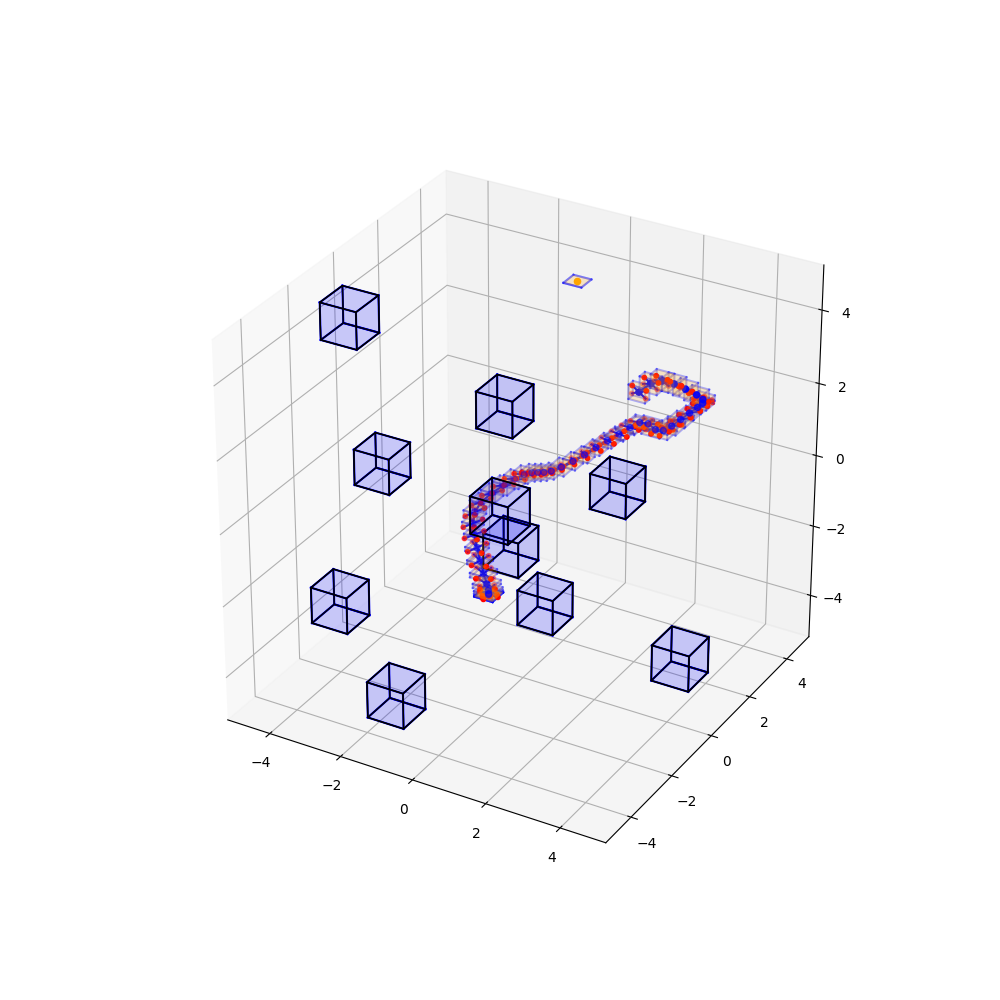

In [4]:
%matplotlib notebook
env_id = 0
valid = False
while not valid:
    start_state = np.array([r(), r(), r(),
                            0, 0, 0, 1,
                            0, 0, 0,
                            0, 0, 0])
    goal_state = np.array([r(), r(), r(),
                            0, 0, 0, 1,
                           0, 0, 0,
                           0, 0, 0])
    if not (valid_state(start_state, obs_list[env_id], radius=2) and valid_state(goal_state, obs_list[env_id], radius=2)) or np.linalg.norm(start_state-goal_state) < 3.0:
        print('invalid states:',start_state, goal_state)
        continue
    planner = plan_sst(params, start_state, goal_state, obs_list[env_id], verbose=True, t_max=300)
    solution = planner.get_solution()

    if solution is not None:
        p_path = post_propagate(start_state, solution, interp_freq=10)
        visualize_quadrotor_path(p_path, start_state, goal_state, obs_list[env_id], savefig=False)
        break

In [ ]:
# for env_id in [0, 1, 2]:
#     for i in range(5):
#         !rm figs/*.png
#         done = False
#         while not done:
#             start_state = np.array([r(), r(), r(),
#                                     0, 0, 0, 1,
#                                     0, 0, 0,
#                                     0, 0, 0])
#             goal_state = np.array([r(), r(), r(),
#                                     0, 0, 0, 1,
#                                    0, 0, 0,
#                                    0, 0, 0])
#             if np.linalg.norm(start_state-goal_state) < 3.0:
#                 continue
#             planner = plan_sst(params, start_state, goal_state, obs_list[env_id], verbose=True, t_max=300)
#             solution = planner.get_solution()
#             if solution is not None:
#                 p_path = post_propagate(start_state, solution, interp_freq=10)
#                 visualize_quadrotor_path(p_path, start_state, goal_state, obs_list[env_id], savefig=True)
#                 make_video(env_id, i)
#                 done = True


# Prepare for datagen

In [9]:
from data_gen.pcd_tools.pcd_generation import rectangle_pcd_3d

In [13]:
pcd_3d = rectangle_pcd_3d(obs_list, 1, num_sample=5000)

<IPython.core.display.Javascript object>


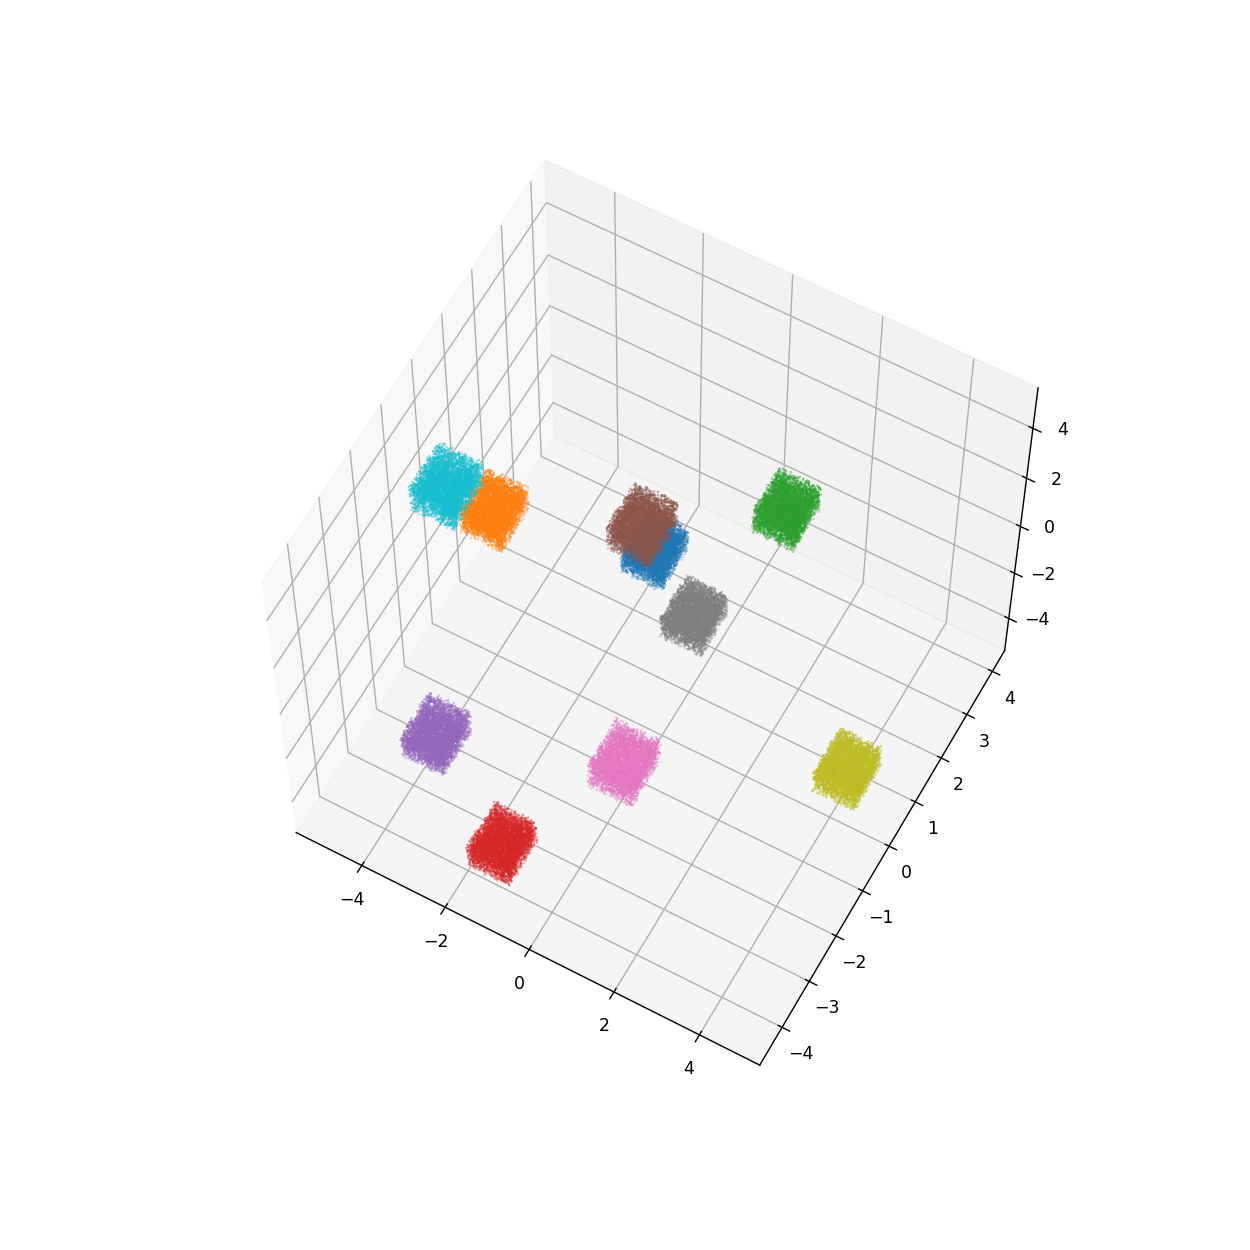

In [16]:
%matplotlib notebook
env_id = 0
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(pcd_3d[env_id].shape[0]):
    pi = pcd_3d[env_id][i]
    ax.scatter(pi[:, 0], pi[:, 1], pi[:, 2], s=0.1)


In [168]:
obs_list.shape

(10, 10, 3)

In [1]:
import numpy as np

vox = np.load('mpnet/sst_envs/data/quadrotor_obs_env_vox.npy')

<IPython.core.display.Javascript object>


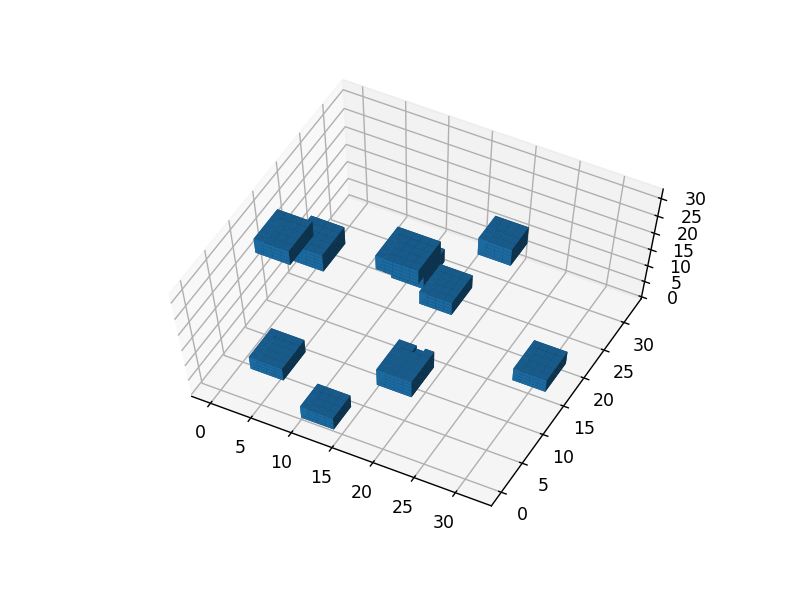

In [15]:
%matplotlib notebook

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(vox[0])

print()

# View path

In [4]:
import pickle
from pathlib import Path
def load_saved_data(env_id=0, t_id=0):
    s = pickle.load(open("./data_gen/trajectories/quadrotor_obs/{env_id}/env{env_id}.pkl".format(env_id=env_id),'rb'))
    id_list = np.array(list(s)[t_id])
    path_id = "_".join(id_list.astype(str).tolist())
    file_fn = lambda f_type: "./data_gen/trajectories/quadrotor_obs/{env_id}/{f_type}{path_id}.pkl".format(env_id=env_id, path_id=path_id, f_type=f_type)
    return [pickle.load(open(file_fn(d_type), 'rb')) for d_type in ['path', 'start_goal', 'cost', 'time']]

def save_data(env_id, t_id):
    try:
        p, sg, c, t = load_saved_data(env_id, t_id)
    
        file_save_fn = lambda f_type: "./data_gen/trajectories/quadrotor_obs/output/{env_id}/{f_type}{t_id}.pkl".format(env_id=env_id, t_id=t_id, f_type=f_type)
        Path('./data_gen/trajectories/quadrotor_obs/output/{env_id}/'.format(env_id=env_id)).mkdir(exist_ok=True)
        pickle.dump(p, open(file_save_fn('path'), 'wb'))
        pickle.dump(sg, open(file_save_fn('start_goal'), 'wb'))
        pickle.dump(c, open(file_save_fn('cost'), 'wb'))
        pickle.dump(t, open(file_save_fn('time'), 'wb'))
    except:
        print(t_id)
        pass
    return True


In [8]:
p, sg, c, t = load_saved_data(env_id=1, t_id=0)

<IPython.core.display.Javascript object>


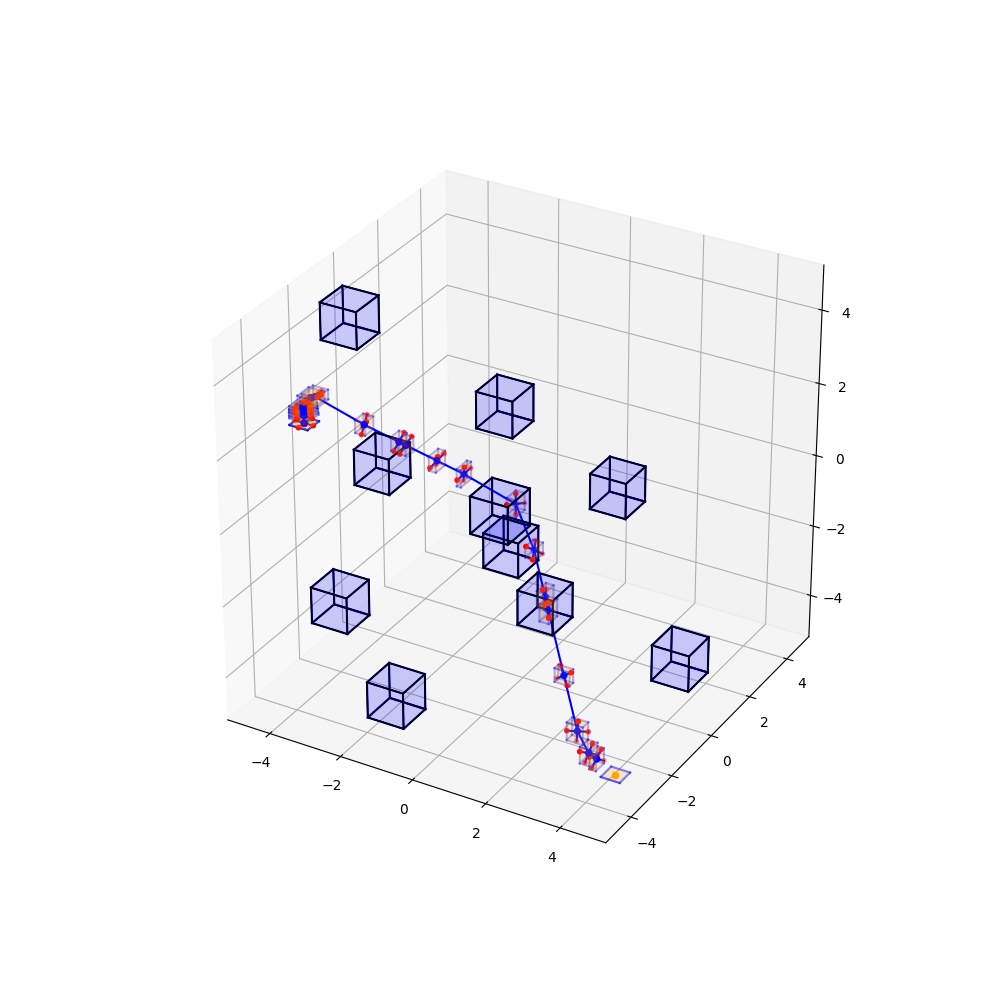

(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7ff575e11048>)

In [6]:
%matplotlib notebook

env_id = 0
visualize_quadrotor_path(p, sg[0], sg[1], obs_list[env_id], savefig=False)


In [17]:
import os
from copy import copy

for env_id in range(4, 10):
    s = pickle.load(open("./data_gen/trajectories/quadrotor_obs/{env_id}/env{env_id}.pkl".format(env_id=env_id),'rb'))

    sbk = copy(s)
    for t_id in tqdm(range(len(s))):
        t_id_tuple = list(s)[t_id]
        id_list = np.array(t_id_tuple)
        path_id = "_".join(id_list.astype(str).tolist())
        file_fn = lambda f_type: "./data_gen/trajectories/quadrotor_obs/{env_id}/{f_type}{path_id}.pkl".format(env_id=env_id, path_id=path_id, f_type=f_type)
    #     try:
    #         [pickle.load(open(file_fn(d_type), 'rb')) for d_type in ['path', 'start_goal', 'cost', 'time']]
    #     except FileNotFoundError:
    #         print(t_id)
    #         sbk.remove(list(s)[t_id])
        for d_type in ['path', 'start_goal', 'cost', 'time']:
            if not os.path.exists(file_fn(d_type)):
                print(t_id_tuple) 
                sbk.remove(t_id_tuple)
    pickle.dump(sbk, open("./data_gen/trajectories/quadrotor_obs/{env_id}/env{env_id}.pkl".format(env_id=env_id), 'wb'))


In [ ]:
from tqdm.auto import tqdm
import multiprocessing


#3 check if all data exists
for env_id in range(6, 10):
    def save_d(traj):
        save_data(env_id, traj)
#     print(env_id)
    pool = multiprocessing.Pool(12)
    
    tasks = list(range(0, 1000))
    for _ in tqdm(pool.imap_unordered(save_d, tasks), total=len(tasks)):
        pass

    
#     pool.map(save_d, list(range(1000)))
#     for traj_id in tqdm(range(1000)):
#         p, sg, c, t = load_saved_data(env_id, traj_id)
#         save_data(env_id, traj_id)
